# Notebook for the deep learning project

<a id='dataset'></a>
# 1 - A first look at the data set

In [1]:
# imports

import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

#import torch
#from torch import nn
#import torch.nn.functional as F
#from torchvision import datasets, transforms, utils
#from torch.utils.data import Dataset, DataLoader
#import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import warnings 
warnings.filterwarnings("ignore") # may not always be the best thing to do...

Using TensorFlow backend.


In [0]:
# extra imports we added

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import cifar10
from keras.models import load_model
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D

from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras import Model

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


**2) Check the shape of images and targets.**

In [4]:
print("The size of the training input is", x_train.shape)
print("The size of the training output is", y_train.shape)

print("The size of the test input is", x_test.shape)
print("The size of the test output is", y_test.shape)

The size of the training input is (50000, 32, 32, 3)
The size of the training output is (50000, 1)
The size of the test input is (10000, 32, 32, 3)
The size of the test output is (10000, 1)


As expected, our input comprises images of dimension 32x32, with three channels: R, G, B.  
The outputs are the labels for these images, represented as an integer: 50,000 outputs of dimension 1 corresponding to the 50,000 images.  
~17% of our data is used as test sample. 

**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck



In [0]:
# Labels' position within the array correspond to their class
labels = ["airplane", 
          "automobile", 
          "bird", 
          "cat", 
          "deer", 
          "dog", 
          "frog", 
          "horse", 
          "ship", 
          "truck"]

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [0]:
# Pixel intensity for each colour channel is represented by a byte from 0 to 255
# We divide our images by 255 to prevent manipulation of high floats
# We do not center the data
x_train = x_train/255
x_test = x_test/255

In [7]:
# Visually checking that our operation worked on image 1
x_train[0]
# All values seem comprised in the [0,1] range

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [0]:
# One hot encoding of our outputs
y_train = tf.keras.utils.to_categorical(y_train, 
                                        num_classes=None, 
                                        dtype='float32')
y_test  = tf.keras.utils.to_categorical(y_test, 
                                        num_classes=None, 
                                        dtype='float32')

In [9]:
# Quick check: our output now has 10 columns, one per class, binarily encoded
print(y_train.shape)
y_train[0:10]

(50000, 10)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

In [10]:
# Creating a dataframe with the first 8 images indices in dataset (rows) for each class (columns)

## Extracting indices
y_train_df = pd.DataFrame(y_train)
indices = []
for j in np.arange(10):
    mask = y_train_df.iloc[:,j] == 1
    indices.append(y_train_df[mask].index[0:8])

## Converting the indices into a dataframe
first8_images = pd.DataFrame(np.array(indices).T)
first8_images

,0,1,2,3,4,5,6,7,8,9
0,29,4,6,9,3,27,0,7,8,1
1,30,5,13,17,10,40,19,11,62,2
2,35,32,18,21,20,51,22,12,69,14
3,49,44,24,26,28,56,23,37,92,15
4,77,45,41,33,34,70,25,43,100,16
5,93,46,42,36,58,81,72,52,106,31
6,115,60,47,38,66,83,95,68,111,50
7,116,61,48,39,82,107,103,73,135,53


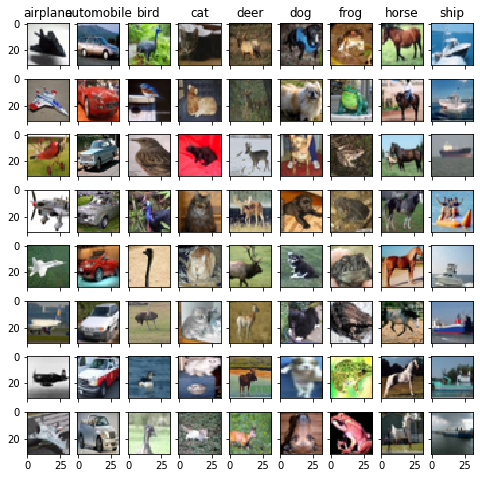

In [11]:
# Printing our first 8 images 
n,p = first8_images.shape
fig, ax = plt.subplots(8, 9, sharex='col', sharey='row', figsize=(8,8))

for k in np.arange(n):
    for j in np.arange(p-1):
        i = first8_images.iloc[k,j]
        ax[k,j].imshow(x_train[i])
        
    cols = labels
    for axis, col in zip(ax[0], cols):
        axis.set_title(col)
    fig

The following code summarizes the previous operations. 

In [0]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    # Loading
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    labels = ["airplane", "automobile", "bird", 
          "cat", "deer", "dog", 
          "frog", "horse", "ship", "truck"]
    
    # Preprocessing: standardising inputs and one-hot encoding outputs
    x_train = x_train/255
    x_test = x_test/255
    
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=None, dtype='float32')
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=None, dtype='float32')
    
    return x_train, y_train, x_test, y_test, labels

In [0]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    
    # Creating a dataframe with the first n images indices in dataset (rows) for each class (columns)
    # Indices associated to the first n images
    categories_df = pd.DataFrame(categories)
    indices = []
    for j in np.arange(categories_df.shape[1]):
        mask = categories_df.iloc[:,j] == 1
        indices.append(categories_df[mask].index[0:n])
    
    # nx10 dataframe with the indices 
    firstn_images = pd.DataFrame(np.array(indices).T)
    
    # Printing our images with their title
    fig, ax = plt.subplots(n, 9, sharex='col', sharey='row', figsize=(8,8))
    for k in np.arange(firstn_images.shape[0]):
        for j in np.arange(firstn_images.shape[1]-1):
            i = firstn_images.iloc[k,j]
            ax[k,j].imshow(x_train[i])
        cols = labels
        for axis, col in zip(ax[0], cols):
                axis.set_title(col)

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [0]:
# Initialising standardised input, one hot encoded output, and labels
x_train, y_train, x_test, y_test, labels = load_cifar_data()

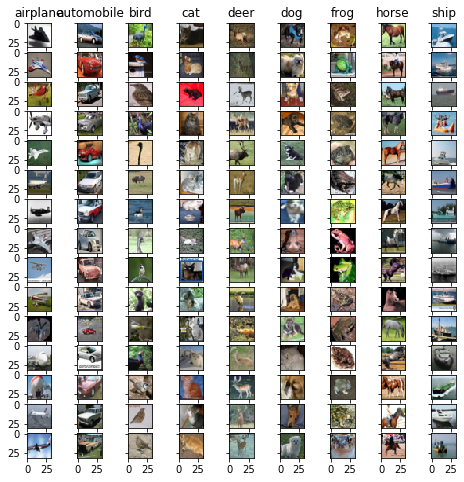

In [15]:
# Showing the first n images by label for n = 15
n = 15
show_first_n_images_in_categories(n, x_train, y_train, labels, file_name=None)

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [0]:
def dense_model(input_shape, num_classes):
    
    hidden_sizes = [2048, 1024, 512, 256]
    
    model = Sequential([
        Flatten(input_shape = input_shape),
        Dense(hidden_sizes[0], input_dim = input_shape, activation='relu'),
        Dense(hidden_sizes[1], activation='relu'),
        Dense(hidden_sizes[2], activation='relu'),
        Dense(hidden_sizes[3], activation='relu'),
        Dense(num_classes, activation='softmax') # softmax activation on the linear output layer
    ])
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='SGD', 
                  metrics=['accuracy'])
    return model

In [17]:
model_dense = dense_model([32,32,3], 10)

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

In [18]:
input_shape = 32*32*3 # this is the equivalent of d in a nxd matrix representing n observations
hidden_sizes = [2048, 1024, 512, 256]
num_classes = 10

# Let us not forget the bias in our computations
# We are dealing solely with dense layers (linear combination and activation)
param1 = (input_shape+1)*hidden_sizes[0] # (d + 1) * output shape
param2 = (hidden_sizes[0]+1)*hidden_sizes[1] # (output from previous layer + 1)* new output shape
param3 = (hidden_sizes[1]+1)*hidden_sizes[2] # idem
param4 = (hidden_sizes[2]+1)*hidden_sizes[3] # idem
param5 = (hidden_sizes[3]+1)*num_classes # idem

print("Total number of parameters", param1 + param2 + param3 + param4 + param5)
print("Per layer", param1, param2, param3, param4, param5)

Total number of parameters 9050378
Per layer 6293504 2098176 524800 131328 2570


**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [19]:
# Yes, we did compute the number of parameters correctly
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
____________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [0]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    cb = EarlyStopping(monitor='accuracy', 
                       min_delta=0, 
                       patience=2, 
                       verbose=0, 
                       mode='auto', 
                       baseline=None, 
                       restore_best_weights=False)
    model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks = [cb], validation_split=0.2)
    return model

In [21]:
model_dense_trained = train_model(model_dense, x_train, y_train)
# model.save('naive_model.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/10





40000/40000 [==============================] - 16s 403us/step - loss: 1.8665 - acc: 0.3320 - val_loss: 1.7328 - val_acc: 0.3872
Epoch 2/10
40000/40000 [==============================] - 7s 165us/step - loss: 1.6625 - acc: 0.4088 - val_loss: 1.6392 - val_acc: 0.4244
Epoch 3/10
40000/40000 [==============================] - 7s 170us/step - loss: 1.5741 - acc: 0.4393 - val_loss: 1.5718 - val_acc: 0.4431
Epoch 4/10
40000/40000 [==============================] - 7s 168us/step - loss: 1.5081 - acc: 0.4641 - val_loss: 1.5244 - val_acc: 0.4614
Epoch 5/10
40000/40000 [==============================] - 7s 169us/step - loss: 1.4546 - acc: 0.4814 - val_loss: 1.5084 - val_acc: 0.4644
Epoch 6/10
40000/40000 [==============================] - 7s 168us/step - loss: 1.4099 - acc: 0.4985 - val_loss: 1.4822 - val_acc: 0.4782
Epoch 7/10
40000/40

Given that we are considering a multiclass problem with more than 2 classes, we can consider accuracy as a good metric for model performance.  
$\textbf{We consider accuracy on the test set to be a good approximation of model generalization, and thus model performance}$.  

In [22]:
#model = load_model("naive_model.hdf5")
model_dense_trained.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 64us/step


[1.3807150230407714, 0.5102]

Accuracy is of $\textbf{~51% on the test set after the 10th epoch}$.

In [23]:
# Counting the number of images for each label in the test set
y_test.sum(axis=0)

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32)

Classes are balanced in the test set: a dummy classifier would be right 10% of the time on any of these categories. Getting 51% test accuracy is much $\textbf{better than random guessing or than a dummy}$.  
However, obtaining the right prediction only half of the time would $\textbf{hinder applications in practice}$.  
Outputting the $\textbf{vector of probabilities to see whether the two or three most probable classes include the true class would be a refined way of considering model performance}$, however we chose to save it for later in this notebook. Accuracy is more readable a metric on 50K images.     
Finally, model $\textbf{performance could be further investigated}$ by looking into the confusion matrix to see if errors are on intuitively 'similar' classes (dogs versus cats) or on distant ones (trucks versus dogs).

**11) Plot several images with their predictions. Any comment?**

In [0]:
# Outputting the predictions as probabilities
predictions = model_dense_trained.predict(x_test)

# Getting the predictions as integers, thus loosing information
df = pd.DataFrame(predictions)

preds = []
for i in np.arange(x_test.shape[0]):
    preds.append(np.where((df.iloc[i,:] == max(df.iloc[i,:])) == True)[0][0])

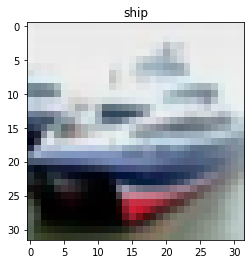

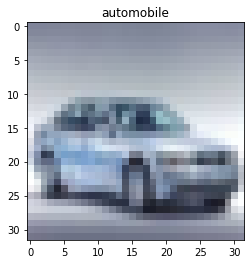

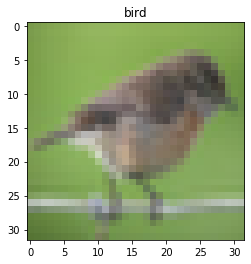

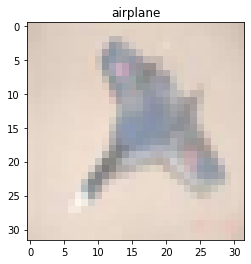

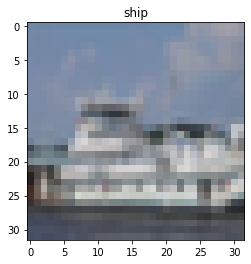

In [25]:
# Selecting random images and their predictions to compare them visually
n = x_test.shape[0]
random_indices = np.random.randint(low=1, high=n, size=5)

for indice in random_indices:
    plt.title(labels[preds[indice]])
    plt.imshow(x_test[indice])
    plt.show()

$\textbf{Comments}$: 
- As expected given our 50% test accuracy, $\textbf{our predictions are mildly accurate}$ on this subsample. As stated earlier, in our configuration it is much better than random guessing: for two equally distributed classes, it would have been comparable to picking a class randomly.
- $\textbf{We lose information}$ when attributing one class to our image: our model outputs a vector of probabilities which we then transform into a determined class prediction. 
- Some predictions are difficult to make even for a human being given the $\textbf{limited image definition}$ (pixellisation).  
- Note that a confusion between a car, a ship and a truck or a cat and a dog is a priori less surprising than between a frog and a truck

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [0]:
def cnn_model(input_shape, num_classes):
    model = Sequential([
            Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'),
            MaxPooling2D(2),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
            MaxPooling2D(2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='SGD', 
                  metrics=['accuracy'])
    return model

In [27]:
model_cnn = cnn_model(x_train.shape[1:], 10)

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

In [0]:
# Filters * (Kernel dimensions * #colours (3) +1)
nb_filters = [32, 32, 64, 64]
dense_output = 512
output_shape = 10
kernel_size = 3*3 # in this case, kernel size was identical between all layers

In [29]:
# Let us not forget to add in the bias
params_1 = (kernel_size*x_train.shape[1:][2]+1)*nb_filters[0] # kernel depth is 3 for the three channels, with one kernel per filter map
params_2 = (kernel_size*nb_filters[0]+1)*nb_filters[1] # kernel depth is now equal to the number of feature maps from the previous layer
params_3 = (kernel_size*nb_filters[1]+1)*nb_filters[2] # idem
params_4 = (kernel_size*nb_filters[2]+1)*nb_filters[3] # idem
params_5 = (nb_filters[3]*np.floor(11/2)*np.floor(11/2)+1)*dense_output # dense layer after a flatten, same calculus as in a traditional ANN
# we could have used the mathematical relation between kernel size, stride and dimensions across previous layers to not hardcode anything
params_6 = (dense_output+1)*output_shape # dense layer
print("Total number of parameters", params_1 + params_2 + params_3 + params_4 + params_5 + params_6)
print("By layer", params_1, params_2, params_3, params_4, params_5, params_6 )

Total number of parameters 890410.0
By layer 896 9248 18496 36928 819712.0 5130


In [30]:
np.floor(30/2)

15.0

We have $\textbf{~10 times less parameters}$ than in the more simple dense network.  
The number of parameters we have to estimate now depends mostly on the $\textbf{kernel size}$ and the number of filters we use.  For the artificial neural network, parameters depended mostly on the number of features, input and output size of each layer. 

In [31]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)             

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [32]:
model_cnn32 = cnn_model(x_train.shape[1:], 10)
model_batch32 = train_model(model_cnn32, 
                    x_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=10, 
                    file_name=None)
#model_batch32.save('cnn_base_model.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 305us/step - loss: 2.0138 - acc: 0.2681 - val_loss: 1.7543 - val_acc: 0.3740
Epoch 2/10
40000/40000 [==============================] - 7s 186us/step - loss: 1.6032 - acc: 0.4249 - val_loss: 1.5110 - val_acc: 0.4534
Epoch 3/10
40000/40000 [==============================] - 7s 186us/step - loss: 1.4351 - acc: 0.4859 - val_loss: 1.3966 - val_acc: 0.5062
Epoch 4/10
40000/40000 [==============================] - 7s 185us/step - loss: 1.3278 - acc: 0.5265 - val_loss: 1.3248 - val_acc: 0.5279
Epoch 5/10
40000/40000 [==============================] - 7s 183us/step - loss: 1.2358 - acc: 0.5598 - val_loss: 1.3250 - val_acc: 0.5219
Epoch 6/10
40000/40000 [==============================] - 7s 184us/step - loss: 1.1569 - acc: 0.5911 - val_loss: 1.2100 - val_acc: 0.5726
Epoch 7/10
40000/40000 [==============================] - 8s 191us/step - loss: 1.0823 - acc: 0.6197 - val_loss: 1.1445 -

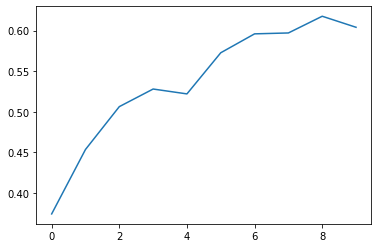

In [33]:
history = History()
plt.plot(model_batch32.history.history['val_acc'])

We observe a $\textbf{jump in validation accuracy from epoch 1 to 2}$: +10% of all images were identified correctly, ~+25% incremental accuracy.  
Validation accuracy then adopts a more linear trend from epochs 2 to 5, with oscillations from epochs 5 to 9, possibly indicative of overfitting.  
  
In parallel, training accuracy starts from a lower point and ends up 6 points higher than validation accuracy at 67%. Training accuracy improves at each epoch, which is what was expected. 

In [34]:
#model_batch32 = load_model("cnn_base_model.hdf5")
model_batch32.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 81us/step


[1.1795674180984497, 0.5967]

Even with overfitting, our base CNN model presents 61% accuracy on the test set, which is a $\textbf{20% performance improvement over the artificial neural network on the same dataset}$.

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [0]:
# Testing different batch sizes, all else equal
batch_sizes = [32, 124, 256, 1024]

In [36]:
model_cnn124 = cnn_model(x_train.shape[1:], 10) # to get independent results when we train the different models
model_batch124 = train_model(model_cnn124, 
                            x_train, 
                            y_train, 
                            batch_size=batch_sizes[1], 
                            epochs=10, 
                            file_name=None)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 100us/step - loss: 2.2732 - acc: 0.1335 - val_loss: 2.1857 - val_acc: 0.2146
Epoch 2/10
40000/40000 [==============================] - 3s 87us/step - loss: 2.0551 - acc: 0.2527 - val_loss: 1.9857 - val_acc: 0.2824
Epoch 3/10
40000/40000 [==============================] - 4s 89us/step - loss: 1.9430 - acc: 0.2997 - val_loss: 1.9828 - val_acc: 0.2794
Epoch 4/10
40000/40000 [==============================] - 3s 87us/step - loss: 1.8488 - acc: 0.3394 - val_loss: 1.8447 - val_acc: 0.3417
Epoch 5/10
40000/40000 [==============================] - 3s 86us/step - loss: 1.7502 - acc: 0.3791 - val_loss: 1.7671 - val_acc: 0.3689
Epoch 6/10
40000/40000 [==============================] - 3s 87us/step - loss: 1.6454 - acc: 0.4174 - val_loss: 1.6223 - val_acc: 0.4165
Epoch 7/10
40000/40000 [==============================] - 3s 85us/step - loss: 1.5662 - acc: 0.4439 - val_loss: 1.5527 - val_ac

In [37]:
model_cnn256 = cnn_model(x_train.shape[1:], 10) 
model_batch256 = train_model(model_cnn256, 
                            x_train, 
                            y_train, 
                            batch_size=batch_sizes[2], 
                            epochs=10, 
                            file_name=None)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 82us/step - loss: 2.2984 - acc: 0.1296 - val_loss: 2.2924 - val_acc: 0.1720
Epoch 2/10
40000/40000 [==============================] - 3s 66us/step - loss: 2.2807 - acc: 0.1982 - val_loss: 2.2588 - val_acc: 0.1909
Epoch 3/10
40000/40000 [==============================] - 3s 66us/step - loss: 2.1841 - acc: 0.2250 - val_loss: 2.2812 - val_acc: 0.1611
Epoch 4/10
40000/40000 [==============================] - 3s 67us/step - loss: 2.0505 - acc: 0.2553 - val_loss: 2.0129 - val_acc: 0.2658
Epoch 5/10
40000/40000 [==============================] - 3s 66us/step - loss: 1.9596 - acc: 0.2941 - val_loss: 1.9506 - val_acc: 0.2998
Epoch 6/10
40000/40000 [==============================] - 3s 66us/step - loss: 1.9094 - acc: 0.3176 - val_loss: 1.9200 - val_acc: 0.3128
Epoch 7/10
40000/40000 [==============================] - 3s 67us/step - loss: 1.8627 - acc: 0.3343 - val_loss: 1.8832 - val_acc

In [38]:
model_cnn1024 = cnn_model(x_train.shape[1:], 10)
model_batch1024 = train_model(model_cnn1024, 
                            x_train, 
                            y_train, 
                            batch_size=batch_sizes[3], 
                            epochs=10, 
                            file_name=None)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 73us/step - loss: 2.2999 - acc: 0.1110 - val_loss: 2.2965 - val_acc: 0.1268
Epoch 2/10
40000/40000 [==============================] - 2s 53us/step - loss: 2.2938 - acc: 0.1332 - val_loss: 2.2903 - val_acc: 0.1312
Epoch 3/10
40000/40000 [==============================] - 2s 54us/step - loss: 2.2868 - acc: 0.1409 - val_loss: 2.2816 - val_acc: 0.1454
Epoch 4/10
40000/40000 [==============================] - 2s 52us/step - loss: 2.2771 - acc: 0.1503 - val_loss: 2.2699 - val_acc: 0.1500
Epoch 5/10
40000/40000 [==============================] - 2s 52us/step - loss: 2.2628 - acc: 0.1615 - val_loss: 2.2518 - val_acc: 0.1644
Epoch 6/10
40000/40000 [==============================] - 2s 52us/step - loss: 2.2398 - acc: 0.1825 - val_loss: 2.2222 - val_acc: 0.1747
Epoch 7/10
40000/40000 [==============================] - 2s 53us/step - loss: 2.2008 - acc: 0.2046 - val_loss: 2.1929 - val_acc

In [0]:
#model_batch32.save('model_batch32.hdf5')
#model_batch124.save('model_batch124.hdf5')
#model_batch256.save('model_batch256.hdf5')
#model_batch1024.save('model_batch1024.hdf5')

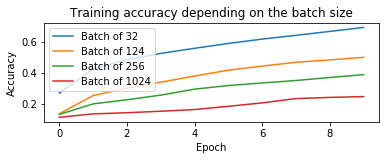

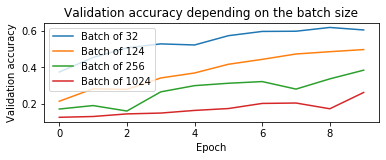

In [40]:
# Plot training accuracy values to be able to have a complete vision on train and test and be able to compare
plt.subplot(2, 1, 1)
plt.plot(model_batch32.history.history['acc'])
plt.plot(model_batch124.history.history['acc'])
plt.plot(model_batch256.history.history['acc'])
plt.plot(model_batch1024.history.history['acc'])
plt.title('Training accuracy depending on the batch size')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Batch of 32', 'Batch of 124', 'Batch of 256', 'Batch of 1024'], loc='upper left')
plt.show()

# Plot validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(model_batch32.history.history['val_acc'])
plt.plot(model_batch124.history.history['val_acc'])
plt.plot(model_batch256.history.history['val_acc'])
plt.plot(model_batch1024.history.history['val_acc'])
plt.title('Validation accuracy depending on the batch size')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.legend(['Batch of 32', 'Batch of 124', 'Batch of 256', 'Batch of 1024'], loc='upper left')
plt.show()

In [41]:
models = [model_batch32, model_batch124, model_batch256, model_batch1024]
test_accuracy = []
for model_test in models: 
  test_accuracy.append(model_test.evaluate(x_test, y_test))
test_accuracy

10000/10000 [==============================] - 1s 79us/step


[[1.1795674180984497, 0.5967],
 [1.3940509855270387, 0.5009],
 [1.747472692680359, 0.3878],
 [2.029846974182129, 0.2647]]

In our example, increasing batch size quickly decreases performance.  
Although increasing batch size encourages quicker convergence, it caused our test error to shoot up. 
To quote Yann LeCun: "Friends don't let friends use mini batches larger than 32", in April 2018 on Twitter.  
To limit training time while avoiding the generalization gap, the key idea is to warm up the learning rate when increasing batch size. 

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

This is symptomatic of $\textbf{overfitting}$: training error goes down, validation error goes up, meaning that our model generalises poorly. In the previous graph, the phenomenon is observed at epoch 6.

In [0]:
def cnn_model_dropout(input_shape, num_classes, dropout_rate=0.25):
    model = Sequential([
            Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'), 
            Dropout(dropout_rate),
            MaxPooling2D(2),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'), 
            Dropout(dropout_rate),
            MaxPooling2D(2),
            Flatten(),
            Dense(512, activation='relu'), 
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='SGD', 
                  metrics=['accuracy'])
    return model

In [43]:
model_dropout025 = cnn_model_dropout(x_train.shape[1:], 10)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
model_dropout025 = train_model(model_dropout025, 
                                        x_train, 
                                        y_train, 
                                        batch_size=32, 
                                        epochs=10, 
                                        file_name=None)
#model_dropout025.save('model_dropout025.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 219us/step - loss: 1.9971 - acc: 0.2724 - val_loss: 1.8409 - val_acc: 0.3767
Epoch 2/10
40000/40000 [==============================] - 8s 201us/step - loss: 1.6567 - acc: 0.4043 - val_loss: 1.6395 - val_acc: 0.4642
Epoch 3/10
40000/40000 [==============================] - 8s 206us/step - loss: 1.4903 - acc: 0.4598 - val_loss: 1.5019 - val_acc: 0.4977
Epoch 4/10
40000/40000 [==============================] - 8s 201us/step - loss: 1.3850 - acc: 0.5004 - val_loss: 1.4813 - val_acc: 0.4938
Epoch 5/10
40000/40000 [==============================] - 8s 205us/step - loss: 1.3047 - acc: 0.5292 - val_loss: 1.3579 - val_acc: 0.5465
Epoch 6/10
40000/40000 [==============================] - 8s 199us/step - loss: 1.2321 - acc: 0.5592 - val_loss: 1.3039 - val_acc: 0.5727
Epoch 7/10
40000/40000 [==============================] - 8s 200us/step - loss: 1.1662 - acc: 0.5850 - val_loss: 1.2452 - 

### Dropout allows to $\textbf{limit overfitting}$: at the 10th epoch, our accuracy and validation accuracy are now very close. 

In [45]:
#model_dropout025 = load_model("model_dropout025.hdf5")
model_dropout025.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 79us/step


[1.0946928926467896, 0.6324]

An 0.25 dropout rate drastically improved our model performance/generalization: our test accuracy shot up from $\textbf{60 to 64%}$ compared to the baseline batch size 32 convolutional neural network.

In [0]:
# Testing two other dropout ratios
dropout_rates = [0.1, 0.5]

In [47]:
model_dropout01 = cnn_model_dropout(x_train.shape[1:], 10, dropout_rate=dropout_rates[0])
model_dropout01 = train_model(model_dropout01, 
                               x_train, 
                               y_train, 
                               batch_size=32, 
                               epochs=10, 
                               file_name=None)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 224us/step - loss: 2.0184 - acc: 0.2617 - val_loss: 1.8824 - val_acc: 0.3312
Epoch 2/10
40000/40000 [==============================] - 8s 205us/step - loss: 1.6571 - acc: 0.4076 - val_loss: 1.5653 - val_acc: 0.4469
Epoch 3/10
40000/40000 [==============================] - 8s 205us/step - loss: 1.4776 - acc: 0.4663 - val_loss: 1.4314 - val_acc: 0.4928
Epoch 4/10
40000/40000 [==============================] - 8s 202us/step - loss: 1.3686 - acc: 0.5109 - val_loss: 1.3571 - val_acc: 0.5126
Epoch 5/10
40000/40000 [==============================] - 8s 208us/step - loss: 1.2781 - acc: 0.5456 - val_loss: 1.2868 - val_acc: 0.5565
Epoch 6/10
40000/40000 [==============================] - 8s 209us/step - loss: 1.1968 - acc: 0.5756 - val_loss: 1.2208 - val_acc: 0.5814
Epoch 7/10
40000/40000 [==============================] - 8s 204us/step - loss: 1.1280 - acc: 0.6017 - val_loss: 1.1847 - 

In [0]:
#model_dropout01.save('cnn_dropout_model01.hdf5')

In [49]:
model_dropout05 = cnn_model_dropout(x_train.shape[1:], 10, dropout_rate=dropout_rates[1])
model_dropout05 = train_model(model_dropout05, 
                               x_train, 
                               y_train, 
                               batch_size=32, 
                               epochs=10, 
                               file_name=None)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 220us/step - loss: 2.0368 - acc: 0.2486 - val_loss: 2.0196 - val_acc: 0.3553
Epoch 2/10
40000/40000 [==============================] - 8s 202us/step - loss: 1.7474 - acc: 0.3650 - val_loss: 1.8756 - val_acc: 0.3677
Epoch 3/10
40000/40000 [==============================] - 8s 203us/step - loss: 1.5733 - acc: 0.4264 - val_loss: 1.7286 - val_acc: 0.4561
Epoch 4/10
40000/40000 [==============================] - 8s 209us/step - loss: 1.4523 - acc: 0.4741 - val_loss: 1.6364 - val_acc: 0.4967
Epoch 5/10
40000/40000 [==============================] - 8s 208us/step - loss: 1.3595 - acc: 0.5115 - val_loss: 1.5861 - val_acc: 0.5042
Epoch 6/10
40000/40000 [==============================] - 8s 203us/step - loss: 1.2906 - acc: 0.5363 - val_loss: 1.5599 - val_acc: 0.5083
Epoch 7/10
40000/40000 [==============================] - 8s 207us/step - loss: 1.2280 - acc: 0.5622 - val_loss: 1.4842 - 

In [0]:
#model_dropout05.save('cnn_dropout_model05.hdf5')

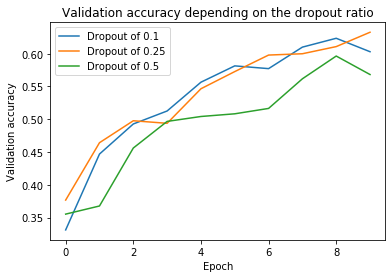

In [51]:
# Plot validation accuracy values
plt.plot(model_dropout01.history.history['val_acc'])
plt.plot(model_dropout025.history.history['val_acc'])
plt.plot(model_dropout05.history.history['val_acc'])
plt.title('Validation accuracy depending on the dropout ratio')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.legend(['Dropout of 0.1', 'Dropout of 0.25', 'Dropout of 0.5'], loc='upper left')
plt.show()

Increasing the dropout ratio tends to limit overfitting under a certain threshold, thus improving model generalization (see model performance on test set below).  
We even obtain similar performances between 0.1 and 0.25 dropout rates in validation accuracy, with a better test error for 0.25. 
Over a certain rate, validation accuracy and generalization decrease: in our example, taking only 50% of network information into account strongly impairs model performance.  
In parallel, the higher the dropout rate, the less computationally expensive it is to train the model and training time tends to decrease.  

There is an optimal dropout rate that by limiting overfitting improves model generalization and limits training time. 

In [52]:
print("Dropout rate 0.1 ", model_dropout01.evaluate(x_test, y_test))
print("Dropout rate 0.25 ", model_dropout025.evaluate(x_test, y_test))
print("Dropout rate 0.5 ", model_dropout05.evaluate(x_test, y_test))

10000/10000 [==============================] - 1s 88us/step
Dropout rate 0.1  [1.1294744145393372, 0.5961]
10000/10000 [==============================] - 1s 82us/step
Dropout rate 0.25  [1.0946928926467896, 0.6324]
10000/10000 [==============================] - 1s 79us/step
Dropout rate 0.5  [1.3480162319183349, 0.5699]


**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [0]:
def cnn_model_dropout_norm(input_shape, num_classes):
    model = Sequential([
            Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'), 
            BatchNormalization(),
            Dropout(0.25),
            MaxPooling2D(2),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
            Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'), 
            Dropout(0.25),
            BatchNormalization(),
            MaxPooling2D(2),
            Flatten(),
            Dense(512, activation='relu'), 
            BatchNormalization(),
            Dropout(0.25),
            Dense(num_classes, activation='softmax')
        ])
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='SGD', 
                  metrics=['accuracy'])
    return model

In [54]:
model_cnn_norm = cnn_model_dropout_norm(x_train.shape[1:], 10)

In [55]:
model_cnn_norm_trained = train_model(model_cnn_norm, 
            x_train, 
            y_train, 
            batch_size=32, 
            epochs=10, 
            file_name=None)
#model_cnn_norm_trained.save('cnn_dropout_norm_model.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 296us/step - loss: 1.7806 - acc: 0.3908 - val_loss: 1.6458 - val_acc: 0.4321
Epoch 2/10
40000/40000 [==============================] - 11s 269us/step - loss: 1.3398 - acc: 0.5301 - val_loss: 1.4820 - val_acc: 0.4780
Epoch 3/10
40000/40000 [==============================] - 11s 268us/step - loss: 1.1864 - acc: 0.5812 - val_loss: 1.5088 - val_acc: 0.4704
Epoch 4/10
40000/40000 [==============================] - 11s 271us/step - loss: 1.0873 - acc: 0.6183 - val_loss: 1.3375 - val_acc: 0.5083
Epoch 5/10
40000/40000 [==============================] - 11s 271us/step - loss: 1.0090 - acc: 0.6453 - val_loss: 1.3100 - val_acc: 0.5497
Epoch 6/10
40000/40000 [==============================] - 11s 269us/step - loss: 0.9465 - acc: 0.6659 - val_loss: 1.0667 - val_acc: 0.6241
Epoch 7/10
40000/40000 [==============================] - 11s 269us/step - loss: 0.8991 - acc: 0.6865 - val_loss: 1.

In [56]:
# Testing model performance
#model_cnn_norm_trained = load_model("model_cnn_norm_trained.hdf5")
model_cnn_norm_trained.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 92us/step


[1.089884474849701, 0.6313]

Batch normalisation drastically improves training accuracy (75% vs 68% earlier), with limited impact on test set performance $\textbf{61% versus 60% accuracy earlier}$.  
In this case, batch normalisation seems to have limited impact on performance versus dropout/(possibly amplified overfitting when we ran the notebook sometimes) while increasing training time. 

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

In [0]:
# Outputting the predictions as probabilities
#model_cnn_norm_trained = load_model("model_cnn_norm_trained.hdf5")

In [0]:
def predict(model, x, labels, file_name=None):
    
    predictions = model.predict(x)
    df = pd.DataFrame(predictions)
    y_pred = []
            
    fig, ax = plt.subplots(x.shape[0], 2, figsize=(8,8))
    
    for row in np.arange(predictions.shape[0]):
        # Getting the class number corresponding to our prediction
        # To be re-used in our confusion matrix
        y_pred.append(np.where((df.iloc[row,:] == max(df.iloc[row,:])) == True)[0][0])
        
        # Plotting image at given row
        ax[row,0].imshow(x_test[row])
        
        # Extracting corresponding vector of probabilities 
        # Then re-ordering the probability vector and the corresponding label array
        predictions_n = predictions[row]
        labels = np.array(labels)
        y_pos = np.arange(len(labels))
        ordering = np.argsort(predictions_n)
        predictions2 = np.sort(predictions_n)[::-1]
        
        # Graphing the probability vector
        ax[row,1].barh(y_pos, predictions2, align='center')
        ax[row,1].set_yticks(y_pos)
        ax[row,1].set_yticklabels(labels[ordering])
        ax[row,1].invert_yaxis()  # labels read top-to-bottom
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
    # Getting model predictions as integers, thus losing information
    return y_pred

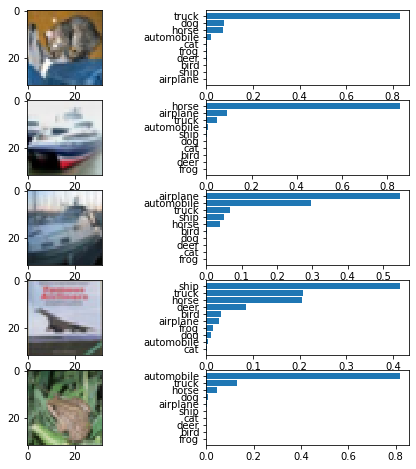

In [59]:
y_pred = predict(model_cnn_norm_trained, x_test[3:8,:,:,:], labels, file_name=None)

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    conf_matrix = confusion_matrix(y_true, np.array(y_pred))
    row_names = ['true ' + x for x in classes]
    col_names = ['predicted ' + x for x in classes]
    conf_matrix = pd.DataFrame(conf_matrix, index = row_names, columns = col_names)
    
    return conf_matrix

In [0]:
# Getting our true labels (coded in numbers from 0 to 9 and not hot-encoded anymore) for the test dataset
y_labels = []
for i in np.arange(len(y_test)):
    y_labels.append(np.where(y_test[i]==1)[0][0])

In [0]:
# Copy of code of q.11 to remember what we did to find the predictions for the test data
# Outputting the predictions as probabilities
predictions = model_cnn_norm_trained.predict(x_test)

# Getting the predictions as integers, thus losing information
df = pd.DataFrame(predictions)

preds = []
for i in np.arange(x_test.shape[0]):
    preds.append(np.where((df.iloc[i,:] == max(df.iloc[i,:])) == True)[0][0])

In [63]:
# Displaying our confusion matrix for the CIFAR-10 dataset using the test data
classes = labels
y_true = y_labels
y_pred = preds
cf_matrix = plot_confusion_matrix(y_true, y_pred, classes)
cf_matrix

,predicted airplane,predicted automobile,predicted bird,predicted cat,predicted deer,predicted dog,predicted frog,predicted horse,predicted ship,predicted truck
true airplane,640,1,148,25,76,6,22,1,74,7
true automobile,37,619,52,46,56,9,44,7,105,25
true bird,33,0,656,53,189,18,43,3,5,0
true cat,5,1,141,538,155,60,87,3,8,2
true deer,3,0,62,42,839,6,36,5,7,0
true dog,2,0,155,259,136,408,30,6,4,0
true frog,0,0,67,55,95,6,774,0,3,0
true horse,6,0,95,70,329,35,13,447,4,1
true ship,47,9,37,38,36,2,16,0,811,4
true truck,35,33,41,73,83,12,50,11,81,581


In [64]:
# Adding colors to better visualize correlations 
cf_matrix.style.background_gradient(cmap='BuPu').set_precision(2)

,predicted airplane,predicted automobile,predicted bird,predicted cat,predicted deer,predicted dog,predicted frog,predicted horse,predicted ship,predicted truck
true airplane,640,1,148,25,76,6,22,1,74,7
true automobile,37,619,52,46,56,9,44,7,105,25
true bird,33,0,656,53,189,18,43,3,5,0
true cat,5,1,141,538,155,60,87,3,8,2
true deer,3,0,62,42,839,6,36,5,7,0
true dog,2,0,155,259,136,408,30,6,4,0
true frog,0,0,67,55,95,6,774,0,3,0
true horse,6,0,95,70,329,35,13,447,4,1
true ship,47,9,37,38,36,2,16,0,811,4
true truck,35,33,41,73,83,12,50,11,81,581


We can make 4 observations:  

- Some categories are correlated in the sense that the algorithm often predicts one instead of the other (eg horse and deer)  
- The fact that two categories look similar does not impact them the same way, which is most visible in precision and recall rather than accuracy.  
For instance,in our model, cat gets much more predicted than dog, meaning that its true positive rate is high (71% of cats were predicted correctly versus an overall of 61%) but its false positive rate also is, especially when 40% of dogs were predicted as cats! Conversely, dogs are seldom detected (42% TPR) because they are often interpreted as cats. 
-  Some categories are better detected than others, such as frog. This may be intuitively explained by the fact that the images seem quite different from other images in our dataset (in shape, colour, spatial structure...). 
- As seen in class, training specialised classifiers on those categories that create confusion could bring our overall accuracy a step further. However, we would clearly compromise on training time.

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks (Bonus !)

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

In [65]:
from tensorflow.keras.models import Model
# Working with ResNet50 model, trained on the imagenet dataset
# Not including the output layer since we have 10 classes instead of 1000
base_model = ResNet50(weights='imagenet', include_top=False)
# Getting a look at our model
base_model.summary()


94658560/94653016 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_________________________

In [0]:
# Loading and preprocessing the dataset in tensorflow
dataset, info = tfds.load("cifar10", as_supervised=True, with_info=True)
labels = info.features["label"].names
n_classes = info.features["label"].num_classes

# Defining the train and test set
train_set = dataset["train"]
test_set = dataset["test"]

In [0]:
# Getting a look at our train set
train_set

In [0]:
# Getting a look at our test set
test_set

In [0]:
# Preprocessing function to feed our input to pre-trained ResNet-50
from keras.applications.resnet50 import preprocess_input
def preprocess(image, label):
    # Resizing the images to fit the input
    # The aspect ratio is already right so no need to crop
    resized_image = tf.image.resize(image,[224,224])
    final_image = preprocess_input(resized_image) # images are already encoded 
    # Imported preprocess_input function for resnet50
    return final_image, label

In [0]:
# Preprocessing the input to allow for treatment by resnet
batch_size = 32
train_set = train_set.map(preprocess).shuffle(1000).batch(batch_size).prefetch(1)

In [0]:
# Checking that our train set has been modified
train_set

In [0]:
# Preparing our output layer to compile our model with 
n_classes = 10
output = Dense(n_classes, activation="softmax")

# Freezing the weights in our base model layers for a pre-training session
for layer in base_model.layers:
  layer.trainable = False

In [0]:
# Creating a sequential object to freely add layers, then compiling the model 
# Using the same loss function and metric as earlier, tweaking the optimizer
new_model = Sequential()
new_model.add(base_model)
new_model.add(output)
optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
new_model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
# Getting a look at our model now
new_model.summary()

In [0]:
# Fitting the model to our dataset 
history = new_model.fit(train_set, epochs=5, batch_size=32, validation_split=True)

In [0]:
for layer in base_model.layers: 
  layer.trainable=True

optimizer = SGD(lr=0.01, momentum=0.9, decay=0.001) # slow learning rate to keep in mind the training we just performed
new_model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])

In [0]:
# Fitting the model to our dataset, training all layers
history = new_model.fit(train_set, epochs=5, batch_size=32, validation_split=0.2)

In [0]:
# Getting model predictions to plot a confusion matrix
pred_resnet50 = new_model.predict(x_test)
# Getting the predictions as integers, thus losing information
preds_resnet50 = []
for i in np.arange(x_test.shape[0]):
  preds_resnet50.append(
      np.where((pred_resnet50[i][0][0] == max(pred_resnet50[i][0][0]))==True)[0][0])
  
# Our network always predicts birds or cats as of today, hurray!
y_true = y_labels
plot_confusion_matrix(y_true, preds_resnet50, classes=labels)